# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [18]:
! pip install Pillow


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 11.01 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ls MNIST

processed  raw


In [5]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


/tmp/ipykernel_16079/482652978.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [6]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

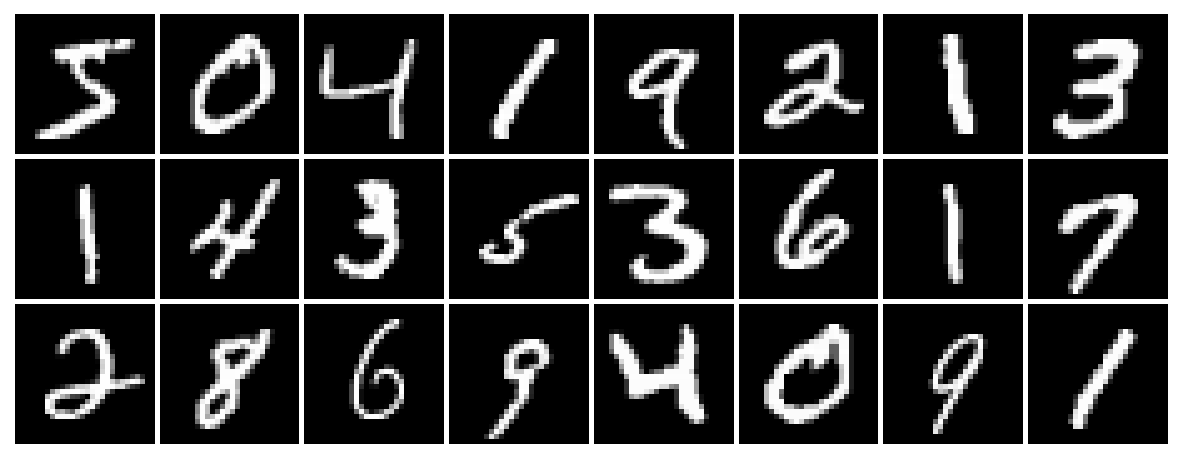

In [7]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


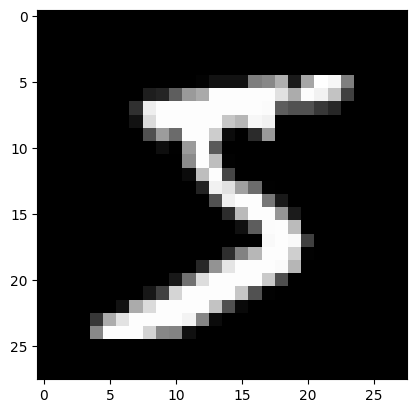

In [8]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [9]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [10]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.1042, -0.0770,  0.2494, -0.1623,  0.1318, -0.0495,  0.2040,  0.2581,
          0.0993, -0.0892],
        [ 0.0720,  0.0594,  0.2366, -0.1750,  0.4923, -0.1903, -0.0385,  0.1134,
          0.0477,  0.0204],
        [ 0.0053, -0.0465,  0.0317, -0.0373,  0.2307, -0.0086, -0.2478,  0.1001,
          0.2802,  0.1243],
        [-0.0583, -0.0129, -0.1347, -0.3963,  0.0288, -0.1758,  0.0299,  0.1203,
          0.2066, -0.0806],
        [-0.1723,  0.0261, -0.0026,  0.0153,  0.0430, -0.0370, -0.3102, -0.1233,
         -0.0244, -0.3639]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [11]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [12]:
#Exercicio 1
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    outputs = model(inputs)  # Predict da rede
    
    # Guarda os valores z0 a z9
    zs.append(outputs[1].detach().numpy())
    
    # Calcula a perda
    loss = criterion(outputs, Variable(y_train))
    
    # Zera gradientes, backpropagation, ajusta parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Calcula predições e acurácia
    losses.append(loss.item())
    _, predicts = torch.max(outputs, 1)
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    # Exibe o número da época, perda e acurácia
    print(f'Epoch[{i + 1}/{epochs}], Loss: {loss.item():.6f}, Accuracy: {accuracy:.6f}')


Epoch[1/100], Loss: 2.297322, Accuracy: 0.097000
Epoch[2/100], Loss: 1.793662, Accuracy: 0.623000
Epoch[3/100], Loss: 1.463487, Accuracy: 0.764000
Epoch[4/100], Loss: 1.243002, Accuracy: 0.765000
Epoch[5/100], Loss: 1.093690, Accuracy: 0.812000
Epoch[6/100], Loss: 0.985344, Accuracy: 0.815000
Epoch[7/100], Loss: 0.905285, Accuracy: 0.833000
Epoch[8/100], Loss: 0.843355, Accuracy: 0.831000
Epoch[9/100], Loss: 0.793710, Accuracy: 0.845000
Epoch[10/100], Loss: 0.752821, Accuracy: 0.848000
Epoch[11/100], Loss: 0.718388, Accuracy: 0.860000
Epoch[12/100], Loss: 0.688877, Accuracy: 0.861000
Epoch[13/100], Loss: 0.663212, Accuracy: 0.865000
Epoch[14/100], Loss: 0.640619, Accuracy: 0.866000
Epoch[15/100], Loss: 0.620523, Accuracy: 0.871000
Epoch[16/100], Loss: 0.602488, Accuracy: 0.876000
Epoch[17/100], Loss: 0.586177, Accuracy: 0.879000
Epoch[18/100], Loss: 0.571326, Accuracy: 0.879000
Epoch[19/100], Loss: 0.557722, Accuracy: 0.881000
Epoch[20/100], Loss: 0.545195, Accuracy: 0.884000
Epoch[21/

Epoch[1/100], Loss: 0.264190, Accuracy: 0.940000


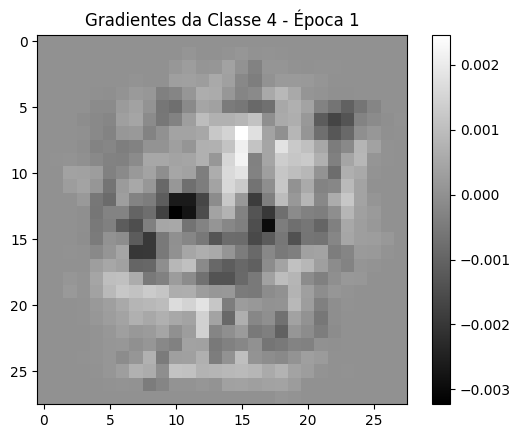

Epoch[2/100], Loss: 0.262872, Accuracy: 0.941000


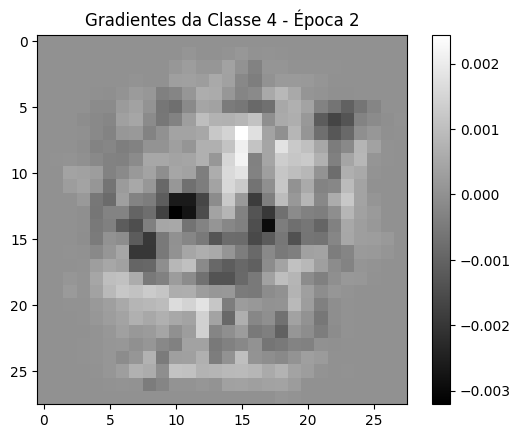

Epoch[3/100], Loss: 0.261569, Accuracy: 0.942000


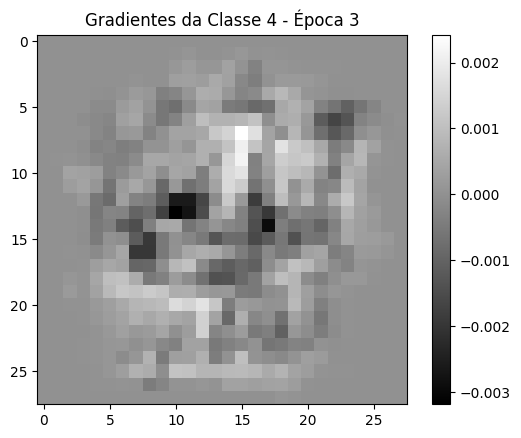

Epoch[4/100], Loss: 0.260282, Accuracy: 0.942000


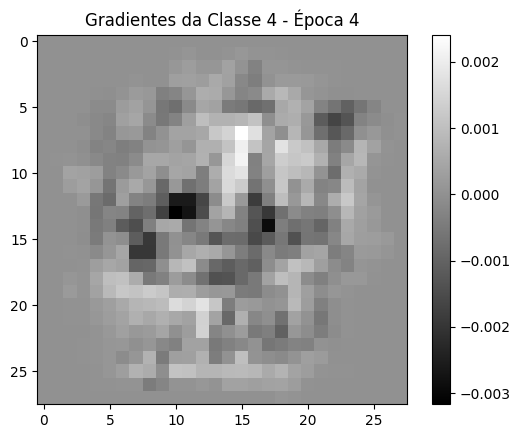

Epoch[5/100], Loss: 0.259009, Accuracy: 0.942000


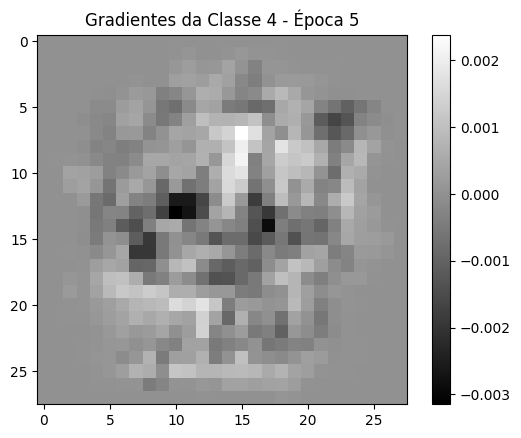

Epoch[6/100], Loss: 0.257750, Accuracy: 0.942000


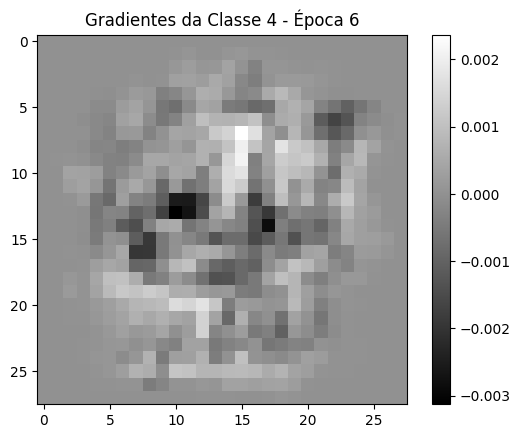

Epoch[7/100], Loss: 0.256506, Accuracy: 0.942000


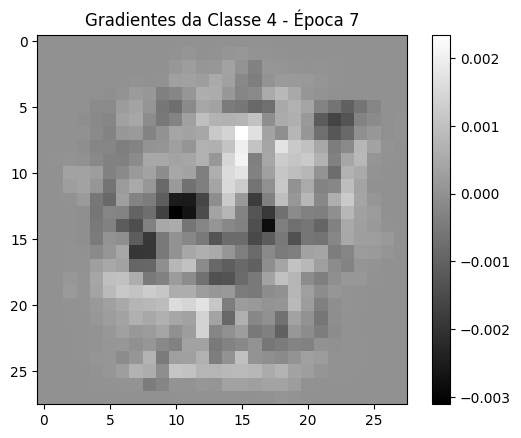

Epoch[8/100], Loss: 0.255276, Accuracy: 0.942000


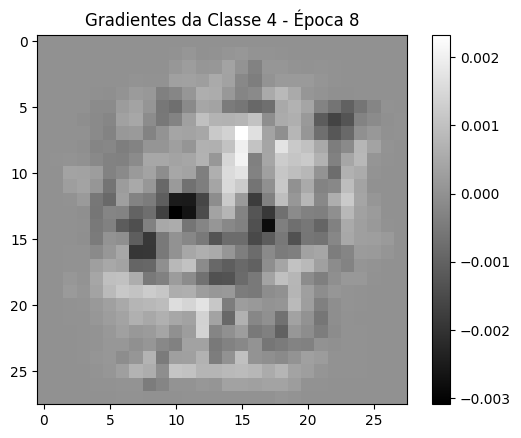

Epoch[9/100], Loss: 0.254060, Accuracy: 0.942000


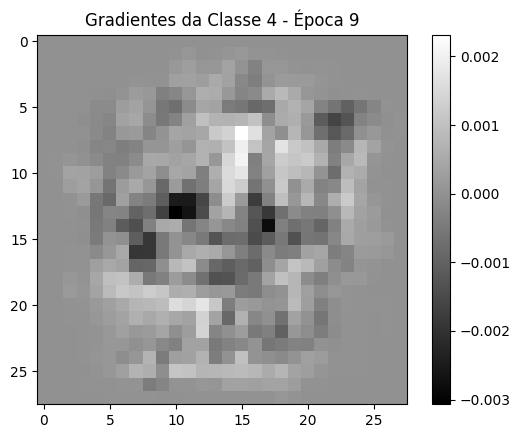

Epoch[10/100], Loss: 0.252856, Accuracy: 0.943000


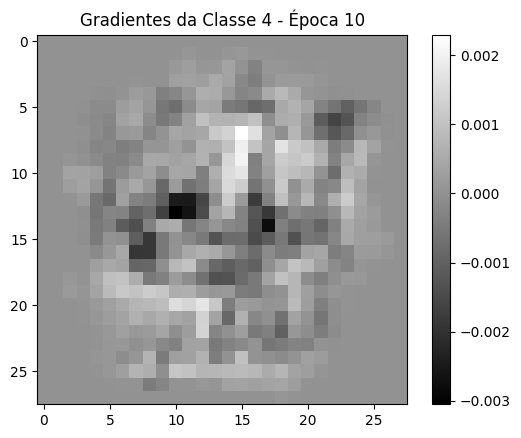

Epoch[11/100], Loss: 0.251666, Accuracy: 0.943000


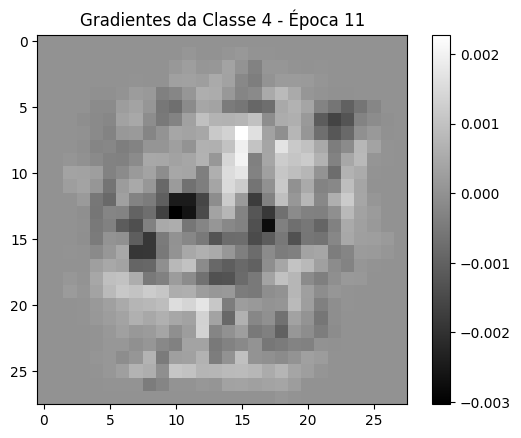

Epoch[12/100], Loss: 0.250489, Accuracy: 0.943000


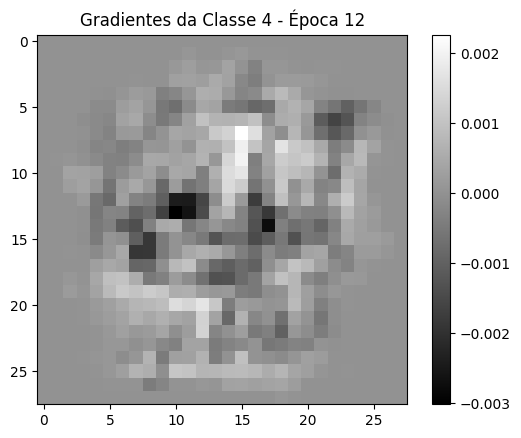

Epoch[13/100], Loss: 0.249324, Accuracy: 0.943000


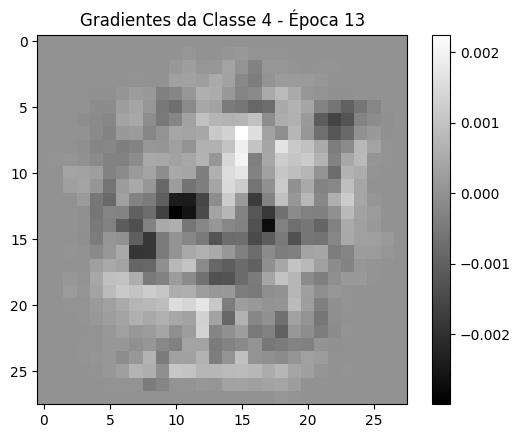

Epoch[14/100], Loss: 0.248172, Accuracy: 0.944000


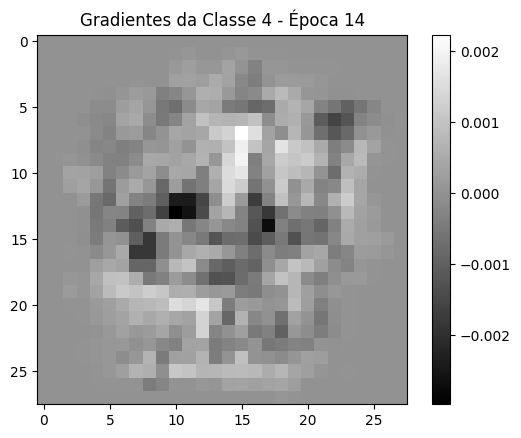

Epoch[15/100], Loss: 0.247031, Accuracy: 0.944000


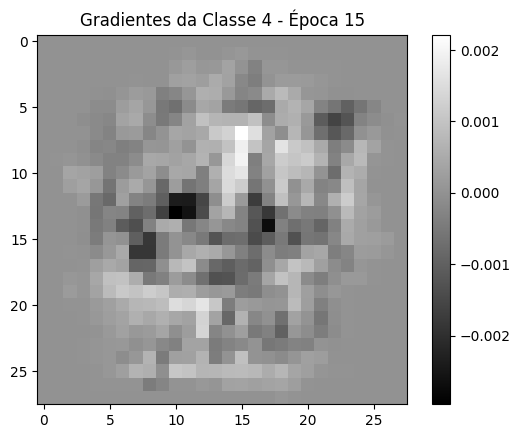

Epoch[16/100], Loss: 0.245903, Accuracy: 0.944000


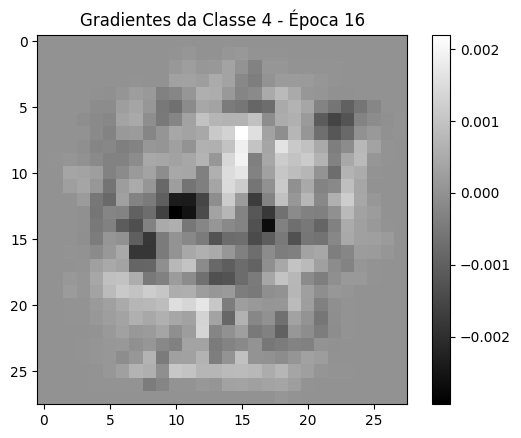

Epoch[17/100], Loss: 0.244786, Accuracy: 0.945000


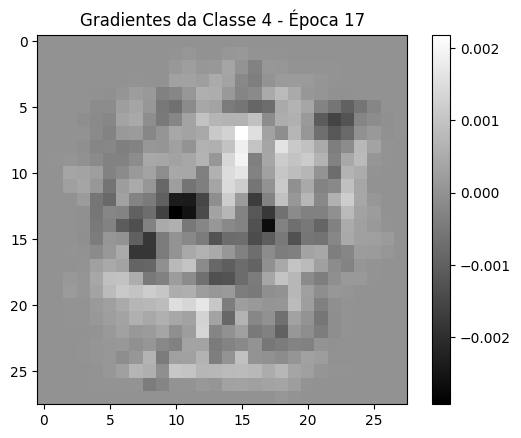

Epoch[18/100], Loss: 0.243680, Accuracy: 0.945000


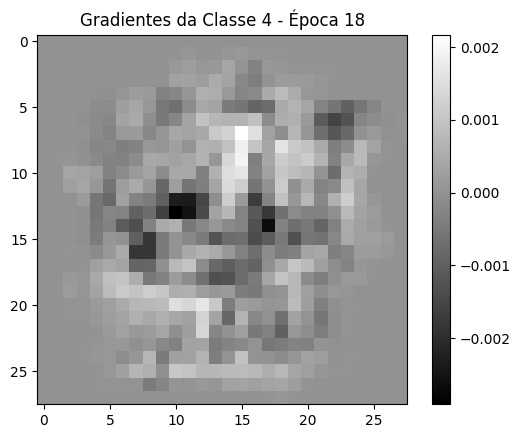

Epoch[19/100], Loss: 0.242586, Accuracy: 0.947000


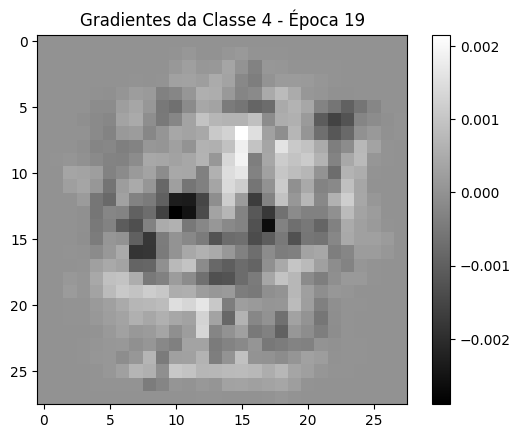

Epoch[20/100], Loss: 0.241502, Accuracy: 0.947000


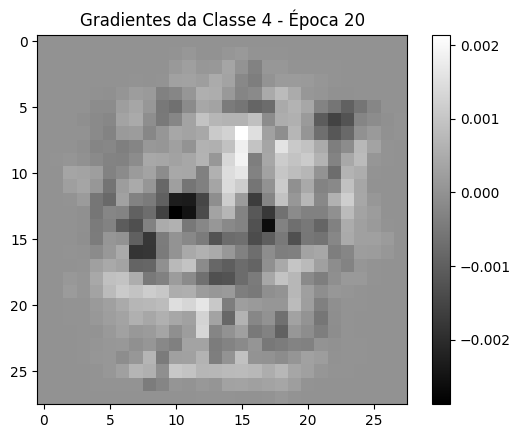

Epoch[21/100], Loss: 0.240430, Accuracy: 0.949000


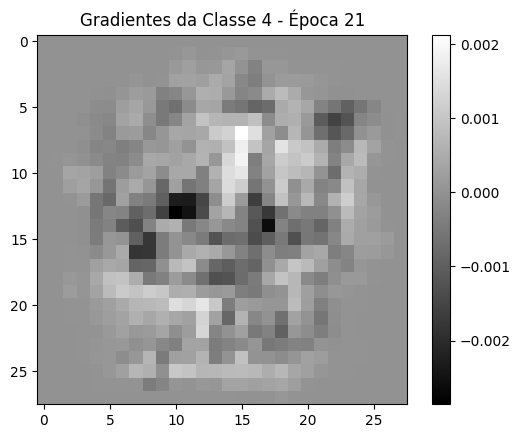

Epoch[22/100], Loss: 0.239368, Accuracy: 0.949000


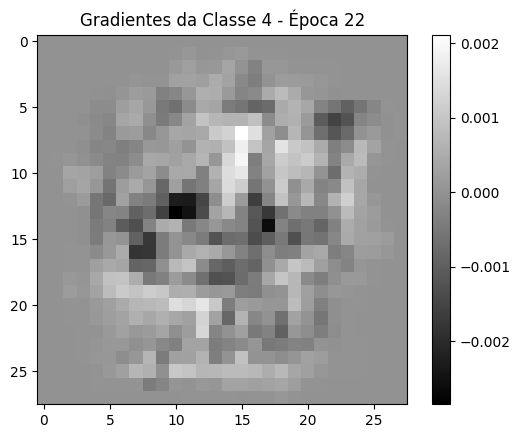

Epoch[23/100], Loss: 0.238316, Accuracy: 0.949000


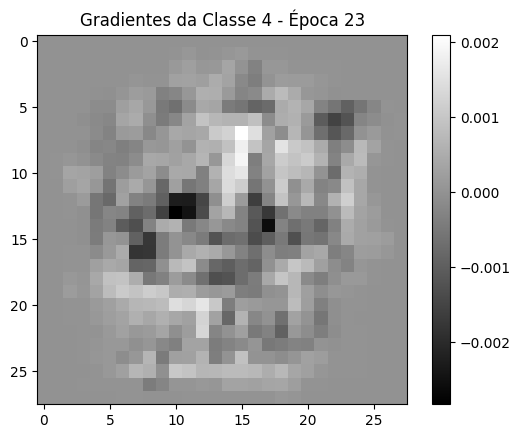

Epoch[24/100], Loss: 0.237274, Accuracy: 0.950000


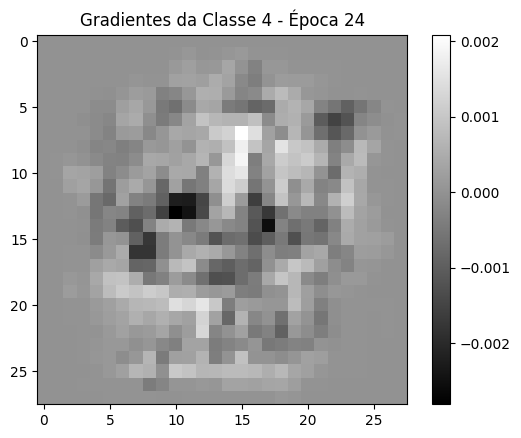

Epoch[25/100], Loss: 0.236243, Accuracy: 0.951000


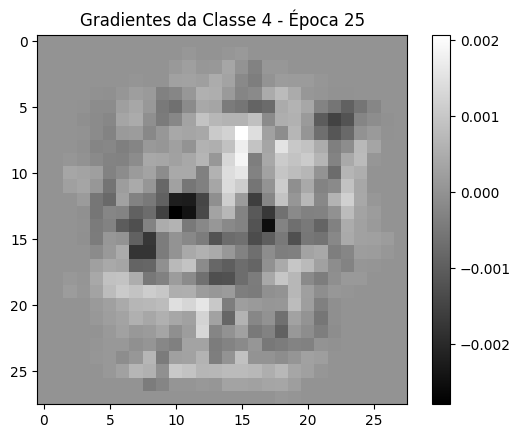

Epoch[26/100], Loss: 0.235221, Accuracy: 0.951000


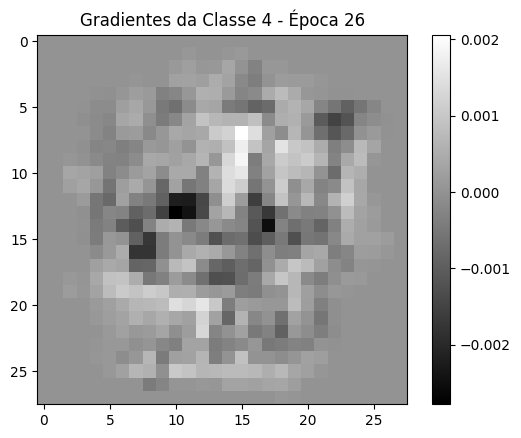

Epoch[27/100], Loss: 0.234209, Accuracy: 0.951000


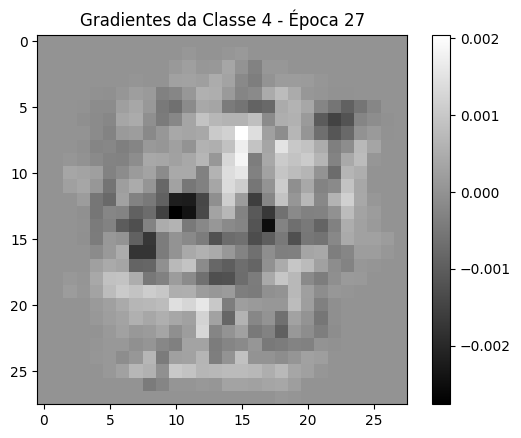

Epoch[28/100], Loss: 0.233207, Accuracy: 0.951000


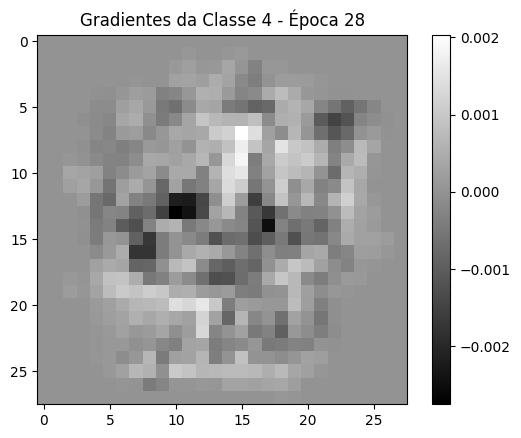

Epoch[29/100], Loss: 0.232214, Accuracy: 0.953000


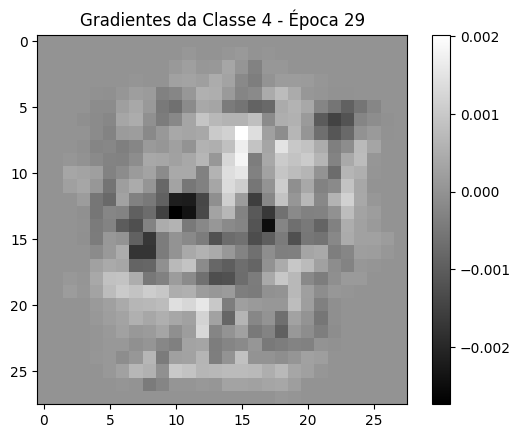

Epoch[30/100], Loss: 0.231230, Accuracy: 0.954000


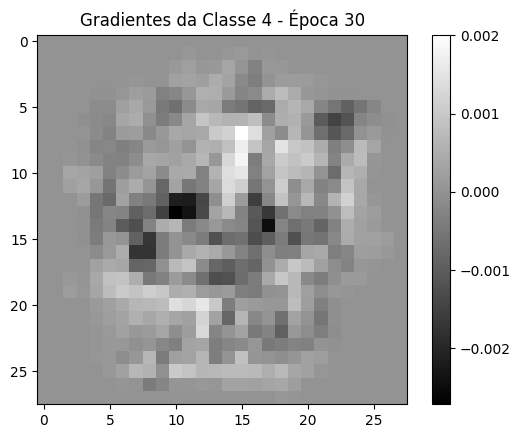

Epoch[31/100], Loss: 0.230255, Accuracy: 0.954000


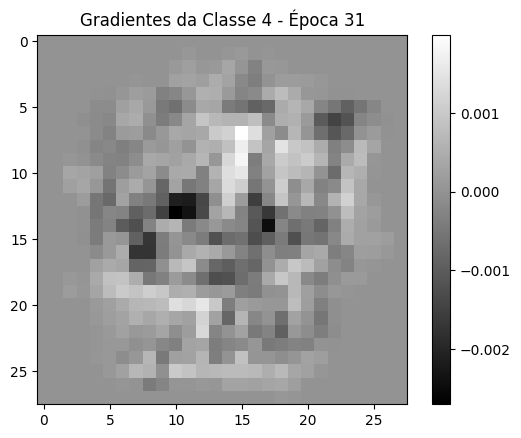

Epoch[32/100], Loss: 0.229289, Accuracy: 0.954000


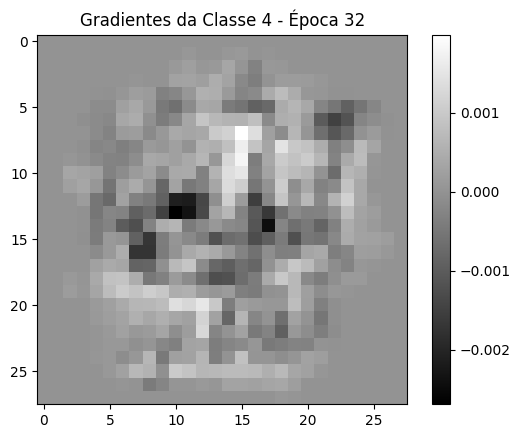

Epoch[33/100], Loss: 0.228332, Accuracy: 0.954000


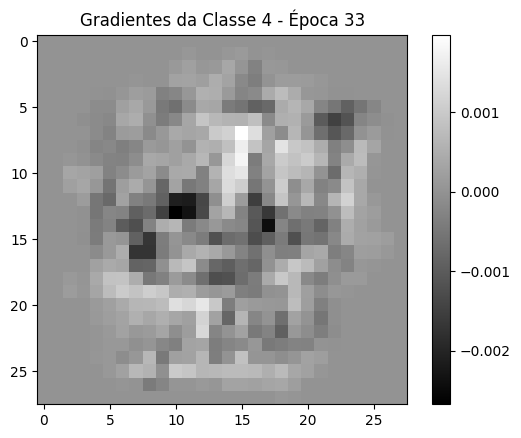

Epoch[34/100], Loss: 0.227383, Accuracy: 0.954000


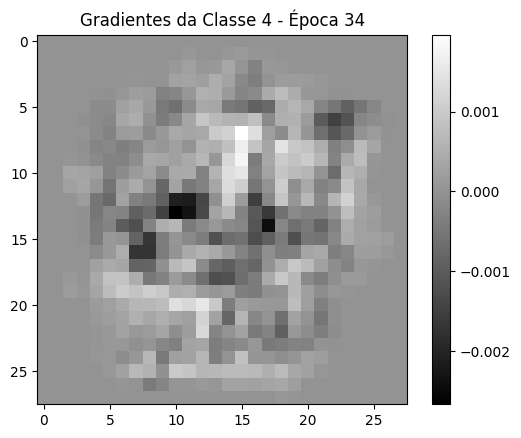

Epoch[35/100], Loss: 0.226443, Accuracy: 0.954000


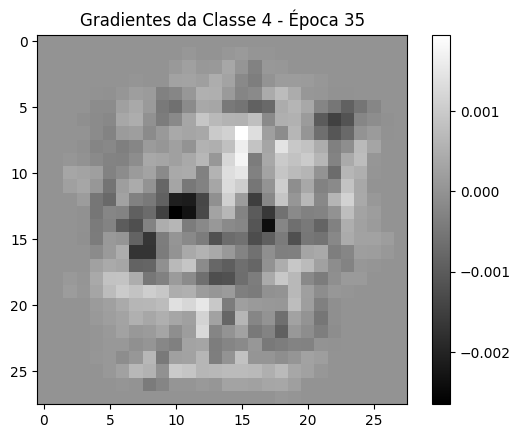

Epoch[36/100], Loss: 0.225511, Accuracy: 0.954000


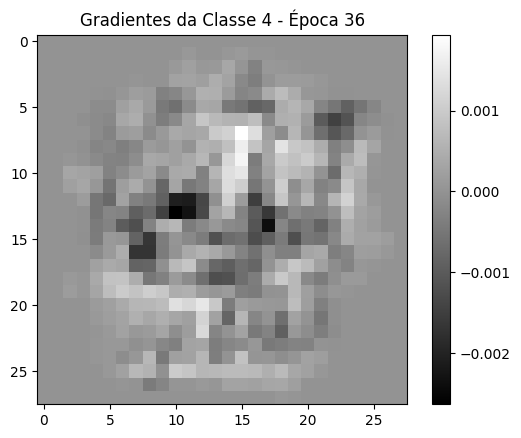

Epoch[37/100], Loss: 0.224588, Accuracy: 0.954000


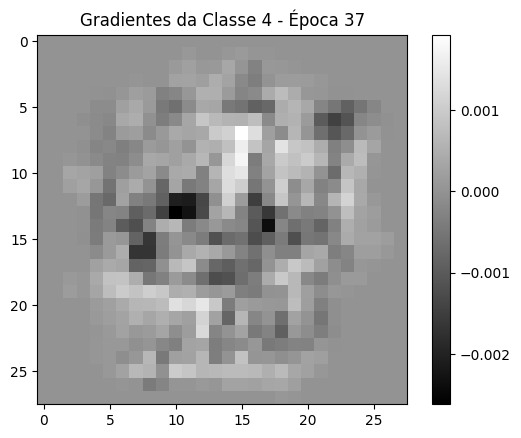

Epoch[38/100], Loss: 0.223672, Accuracy: 0.954000


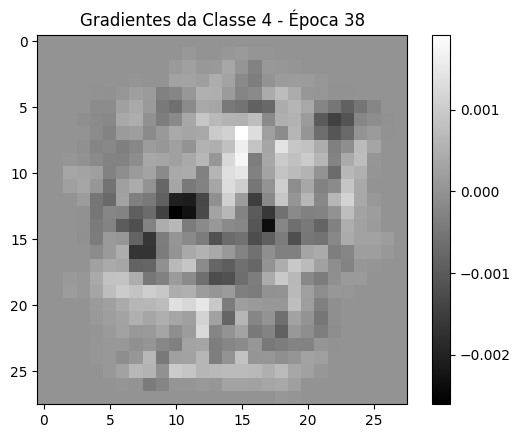

Epoch[39/100], Loss: 0.222764, Accuracy: 0.955000


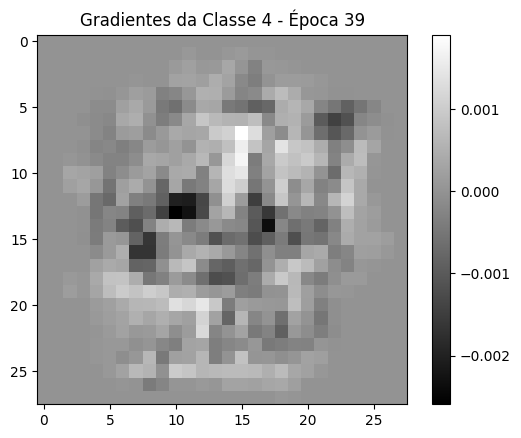

Epoch[40/100], Loss: 0.221865, Accuracy: 0.955000


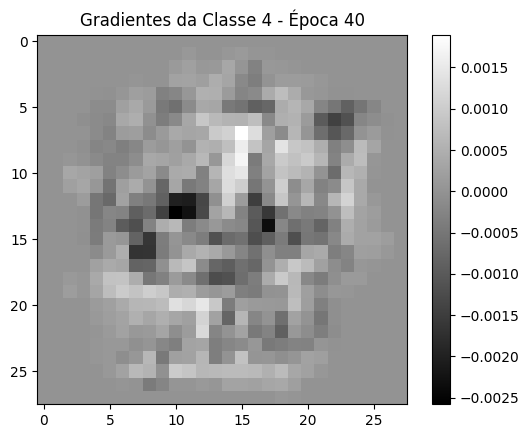

Epoch[41/100], Loss: 0.220972, Accuracy: 0.955000


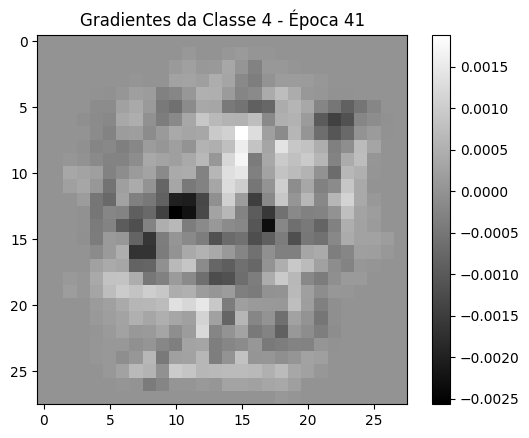

Epoch[42/100], Loss: 0.220088, Accuracy: 0.957000


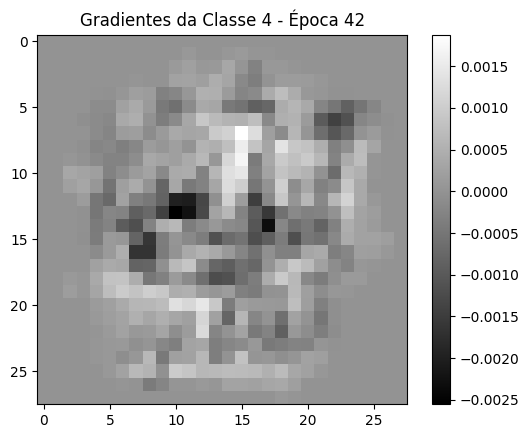

Epoch[43/100], Loss: 0.219211, Accuracy: 0.958000


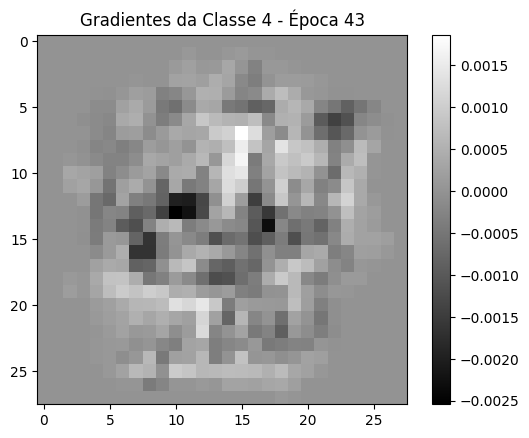

Epoch[44/100], Loss: 0.218341, Accuracy: 0.958000


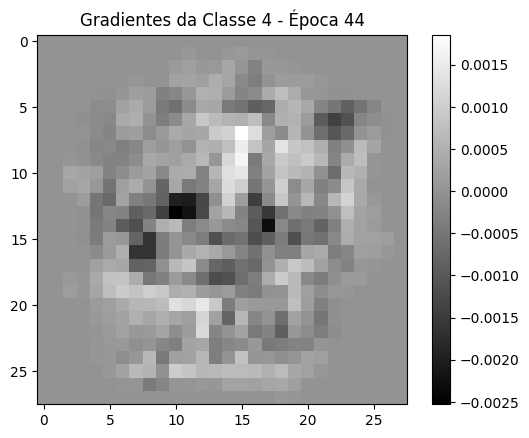

Epoch[45/100], Loss: 0.217479, Accuracy: 0.958000


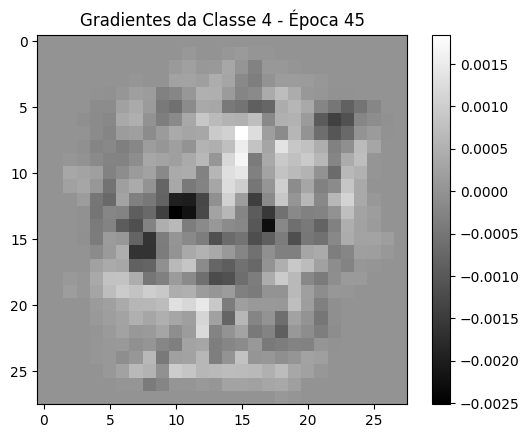

Epoch[46/100], Loss: 0.216623, Accuracy: 0.958000


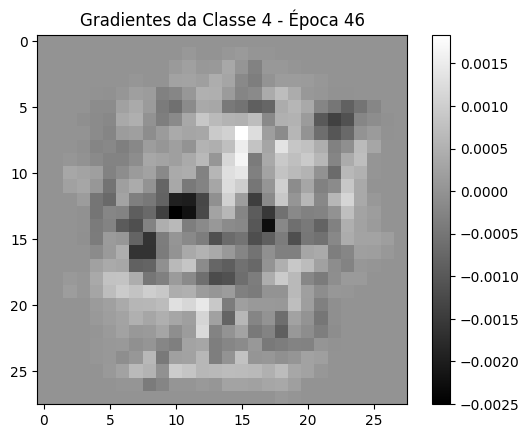

Epoch[47/100], Loss: 0.215775, Accuracy: 0.958000


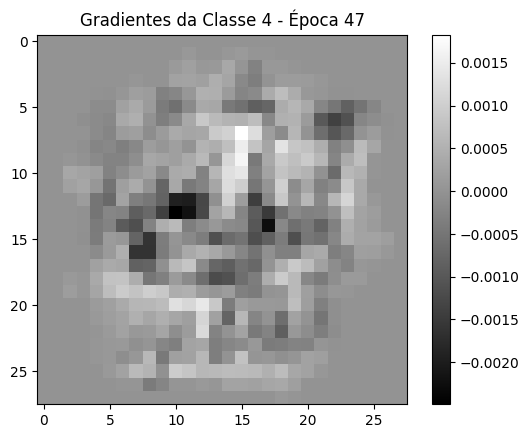

Epoch[48/100], Loss: 0.214934, Accuracy: 0.958000


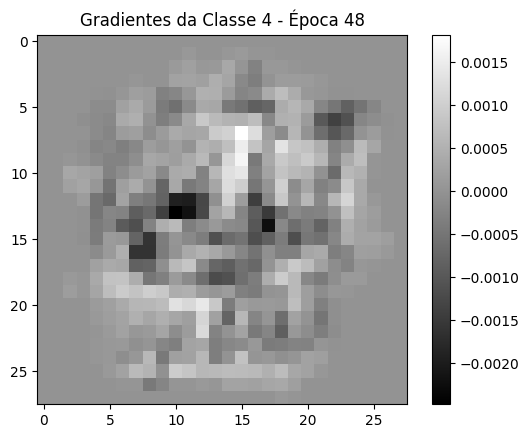

Epoch[49/100], Loss: 0.214099, Accuracy: 0.958000


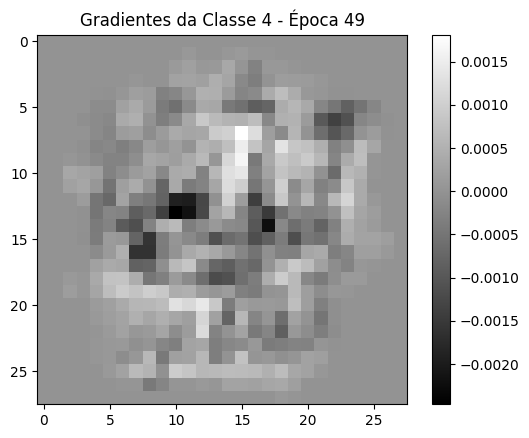

Epoch[50/100], Loss: 0.213271, Accuracy: 0.958000


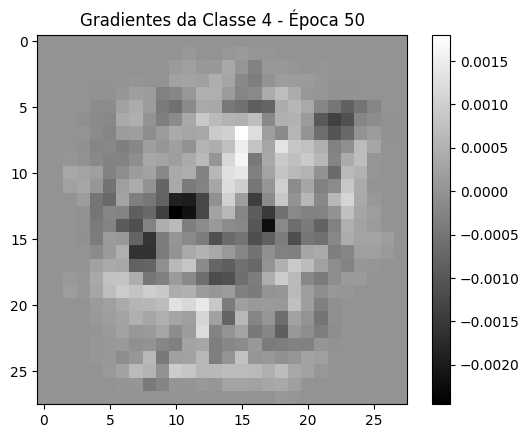

Epoch[51/100], Loss: 0.212450, Accuracy: 0.958000


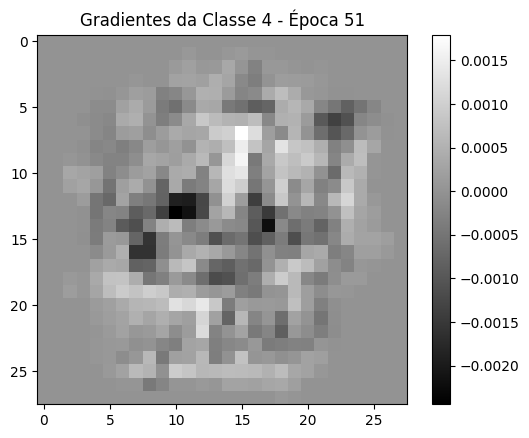

Epoch[52/100], Loss: 0.211636, Accuracy: 0.958000


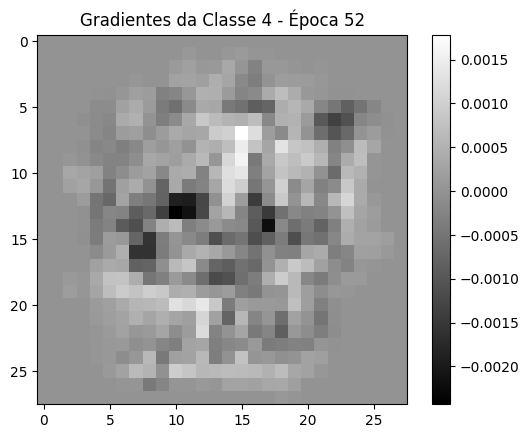

Epoch[53/100], Loss: 0.210827, Accuracy: 0.958000


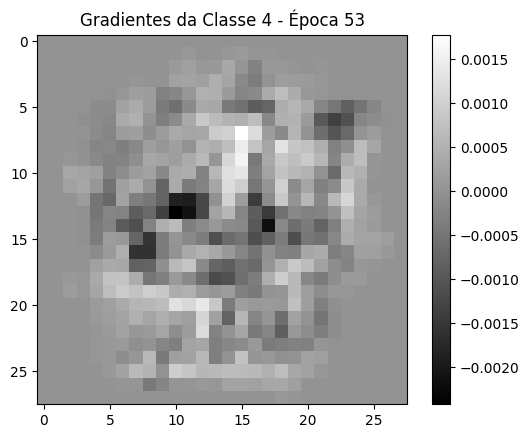

Epoch[54/100], Loss: 0.210026, Accuracy: 0.958000


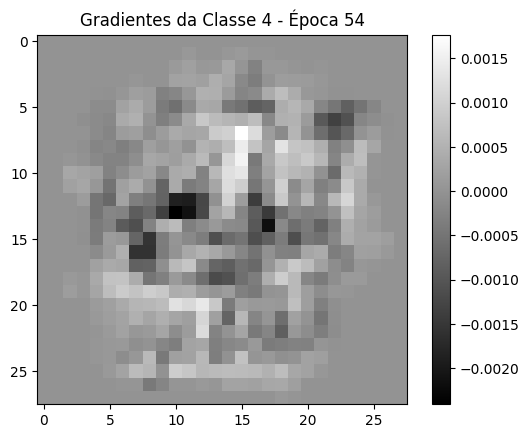

Epoch[55/100], Loss: 0.209230, Accuracy: 0.958000


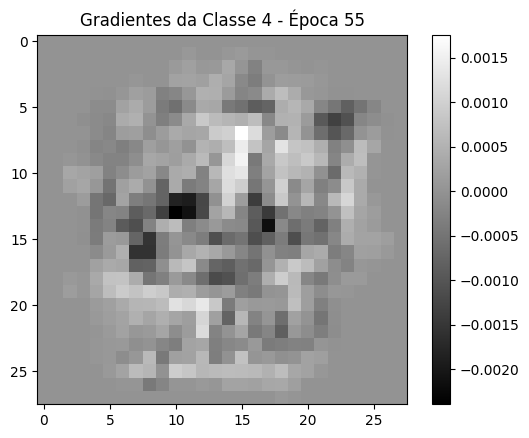

Epoch[56/100], Loss: 0.208441, Accuracy: 0.958000


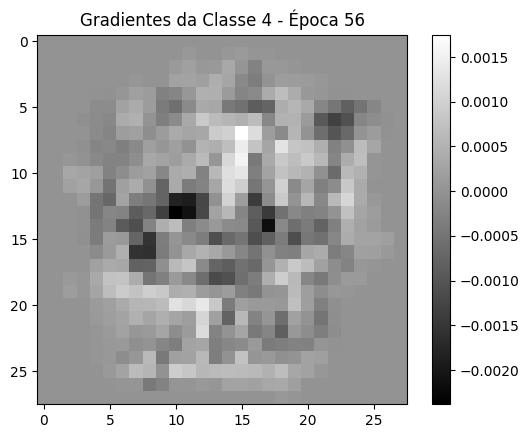

Epoch[57/100], Loss: 0.207658, Accuracy: 0.958000


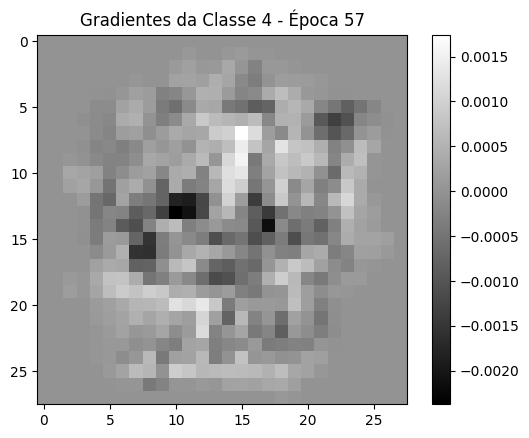

Epoch[58/100], Loss: 0.206880, Accuracy: 0.959000


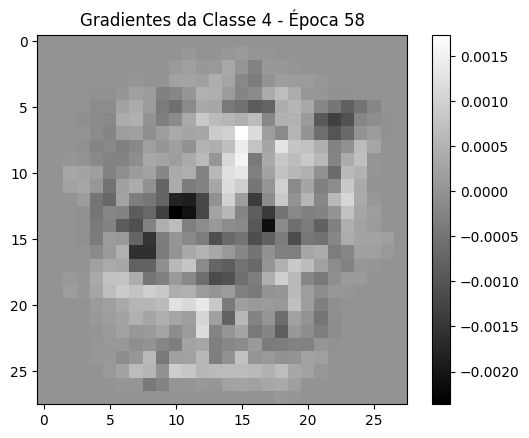

Epoch[59/100], Loss: 0.206109, Accuracy: 0.959000


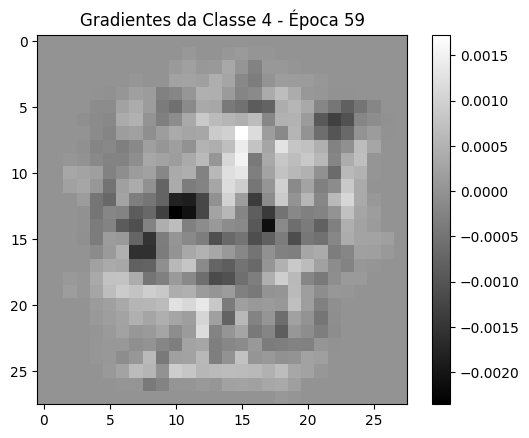

Epoch[60/100], Loss: 0.205344, Accuracy: 0.959000


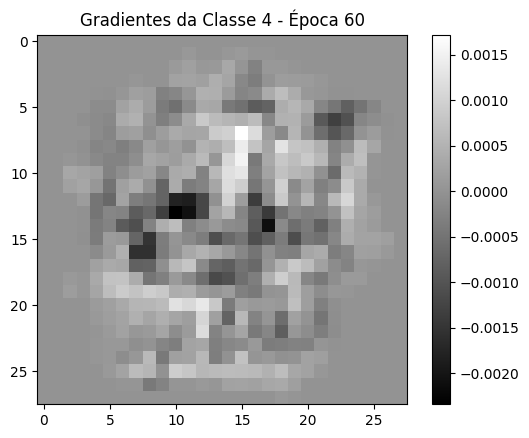

Epoch[61/100], Loss: 0.204584, Accuracy: 0.960000


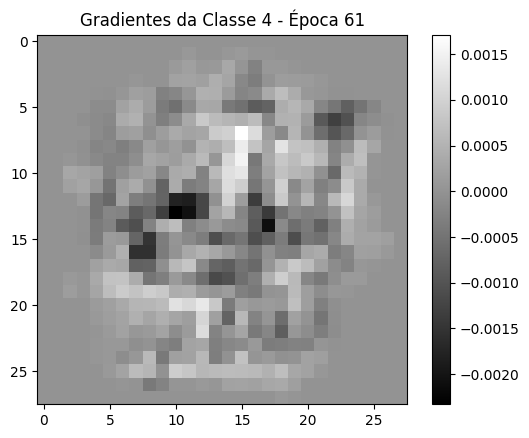

Epoch[62/100], Loss: 0.203830, Accuracy: 0.960000


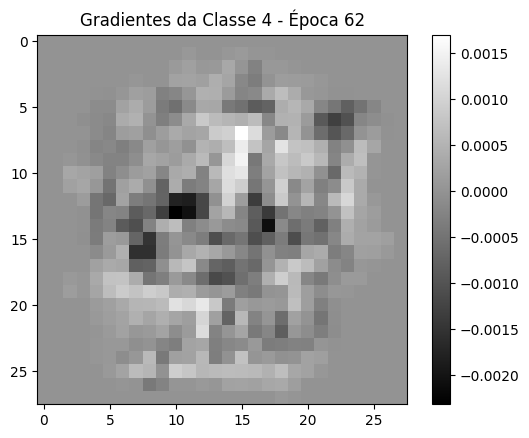

Epoch[63/100], Loss: 0.203082, Accuracy: 0.961000


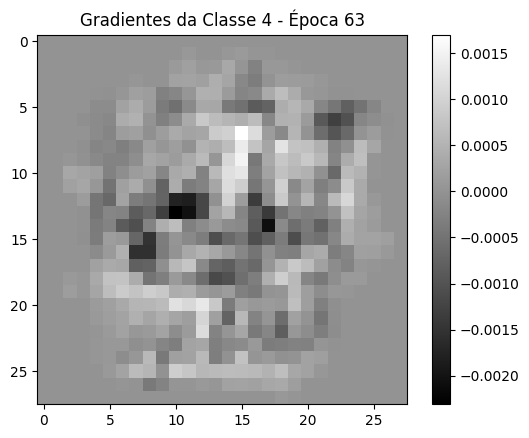

Epoch[64/100], Loss: 0.202340, Accuracy: 0.961000


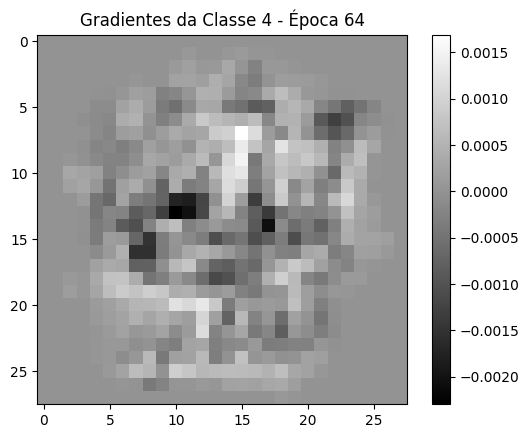

Epoch[65/100], Loss: 0.201603, Accuracy: 0.961000


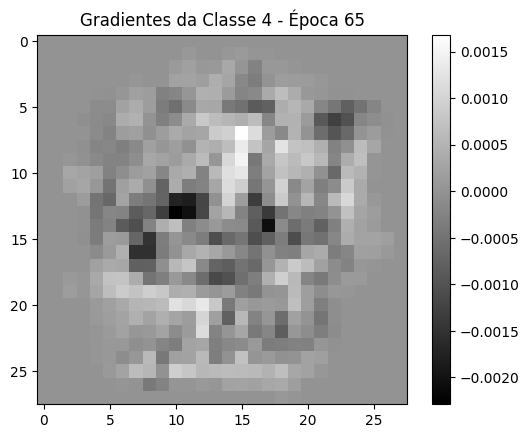

Epoch[66/100], Loss: 0.200871, Accuracy: 0.961000


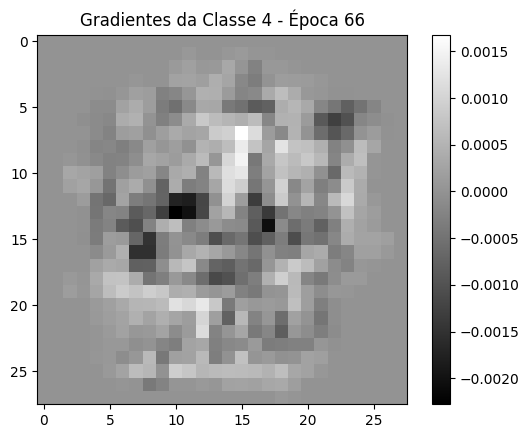

Epoch[67/100], Loss: 0.200144, Accuracy: 0.961000


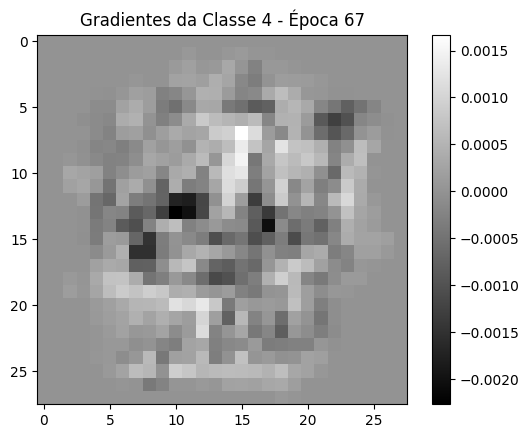

Epoch[68/100], Loss: 0.199423, Accuracy: 0.961000


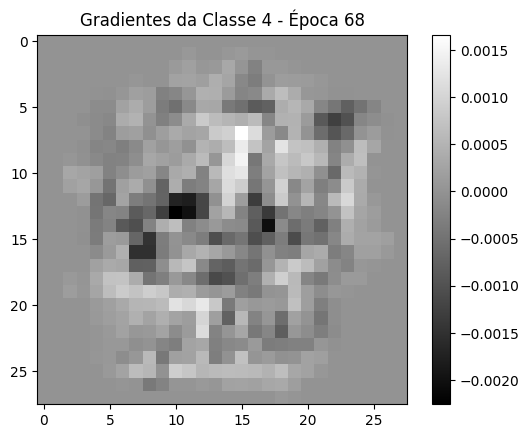

Epoch[69/100], Loss: 0.198708, Accuracy: 0.961000


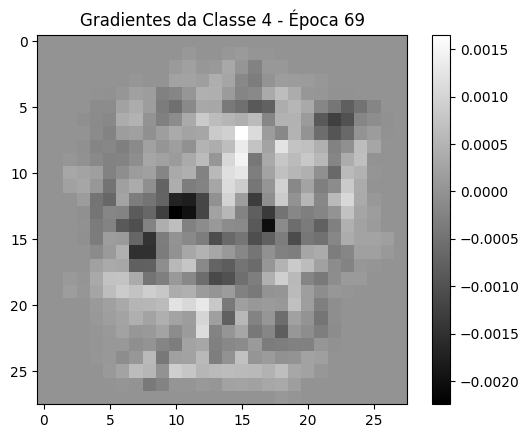

Epoch[70/100], Loss: 0.197997, Accuracy: 0.961000


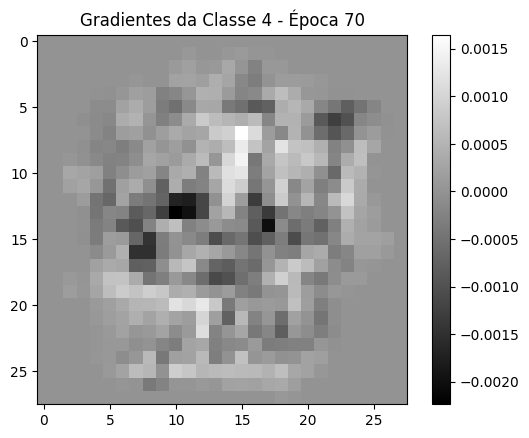

Epoch[71/100], Loss: 0.197291, Accuracy: 0.961000


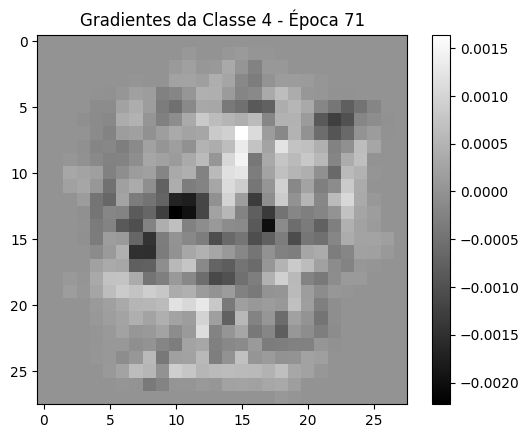

Epoch[72/100], Loss: 0.196591, Accuracy: 0.962000


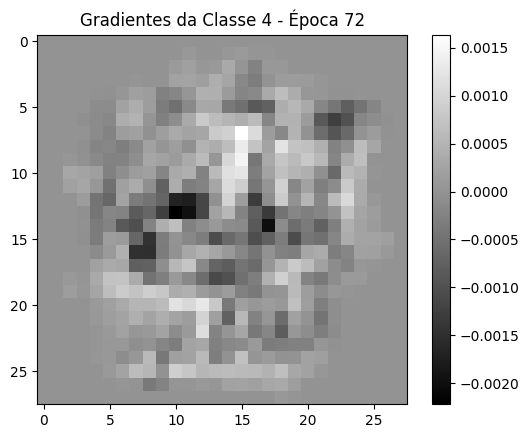

Epoch[73/100], Loss: 0.195895, Accuracy: 0.962000


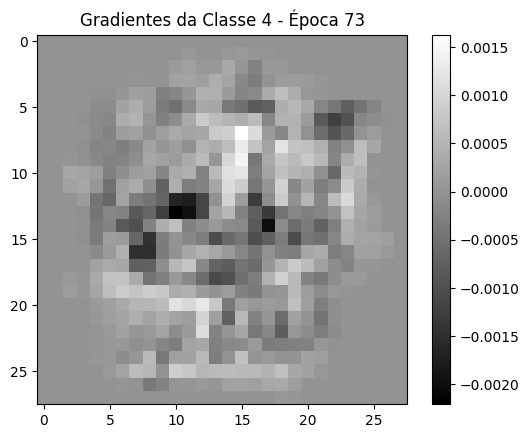

Epoch[74/100], Loss: 0.195205, Accuracy: 0.962000


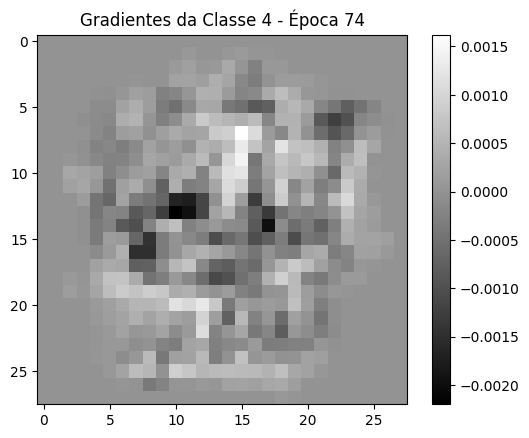

Epoch[75/100], Loss: 0.194519, Accuracy: 0.963000


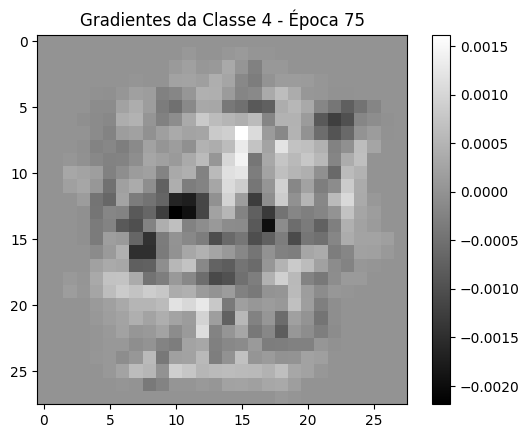

Epoch[76/100], Loss: 0.193838, Accuracy: 0.964000


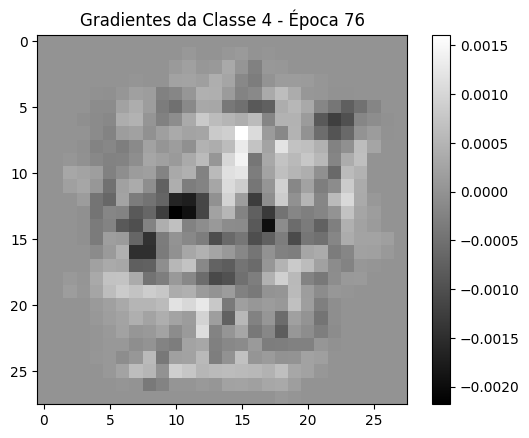

Epoch[77/100], Loss: 0.193162, Accuracy: 0.964000


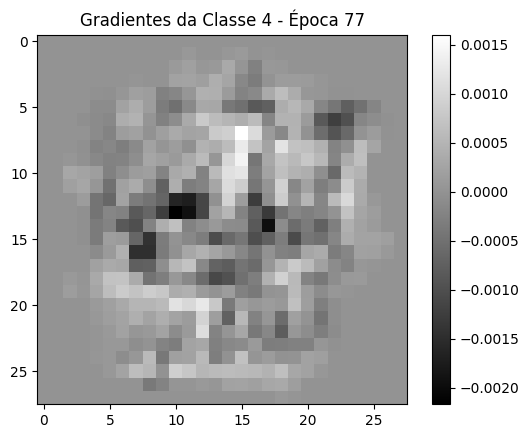

Epoch[78/100], Loss: 0.192490, Accuracy: 0.964000


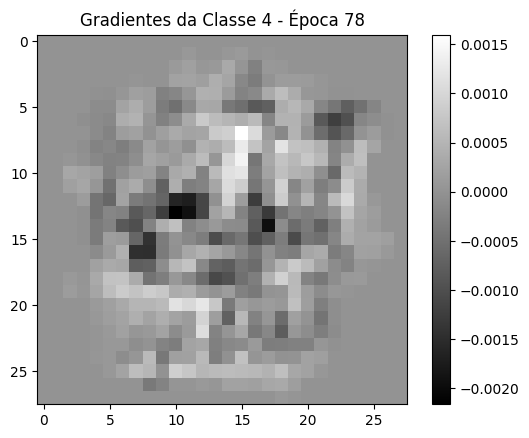

Epoch[79/100], Loss: 0.191823, Accuracy: 0.965000


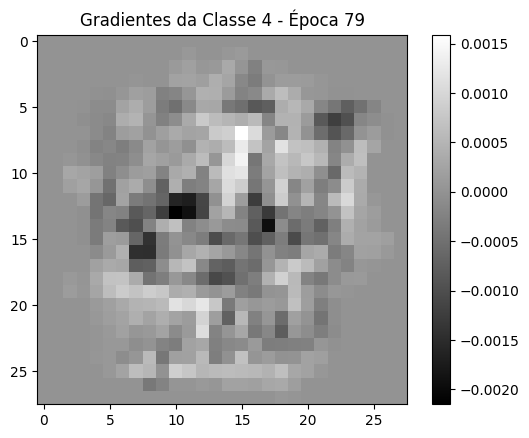

Epoch[80/100], Loss: 0.191161, Accuracy: 0.965000


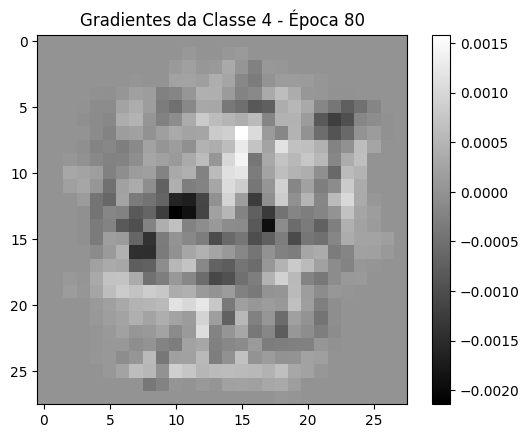

Epoch[81/100], Loss: 0.190503, Accuracy: 0.965000


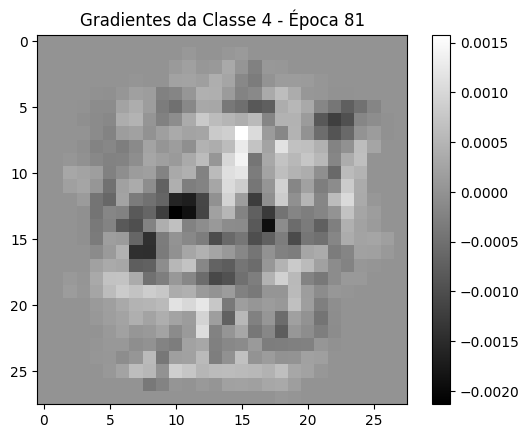

Epoch[82/100], Loss: 0.189850, Accuracy: 0.965000


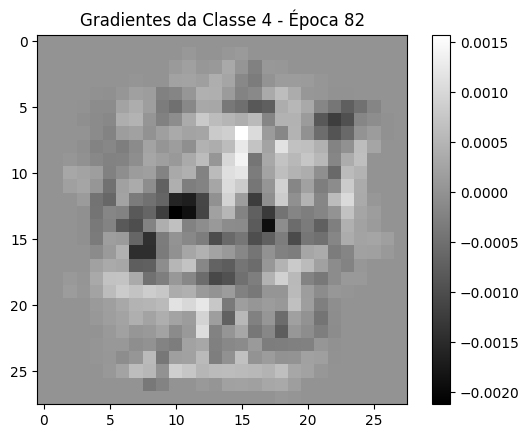

Epoch[83/100], Loss: 0.189201, Accuracy: 0.965000


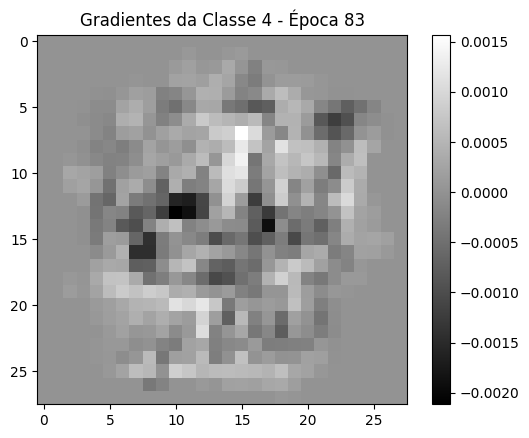

Epoch[84/100], Loss: 0.188557, Accuracy: 0.965000


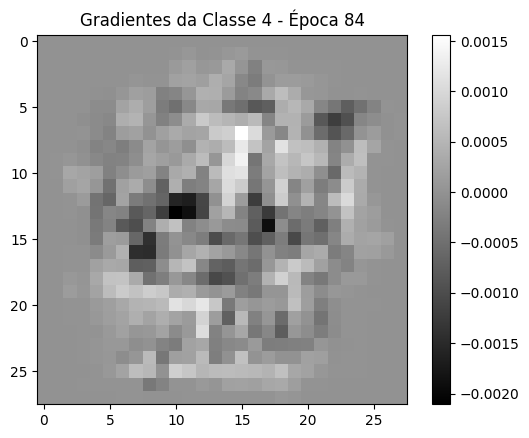

Epoch[85/100], Loss: 0.187916, Accuracy: 0.965000


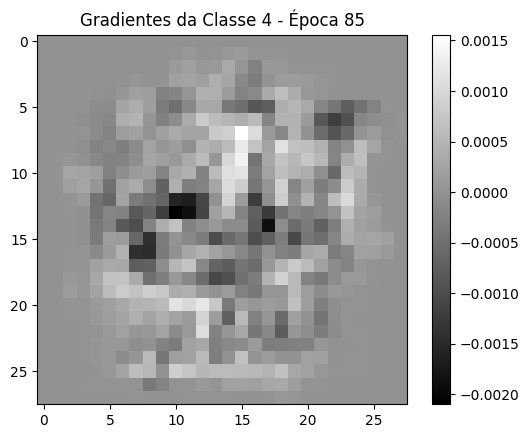

Epoch[86/100], Loss: 0.187280, Accuracy: 0.965000


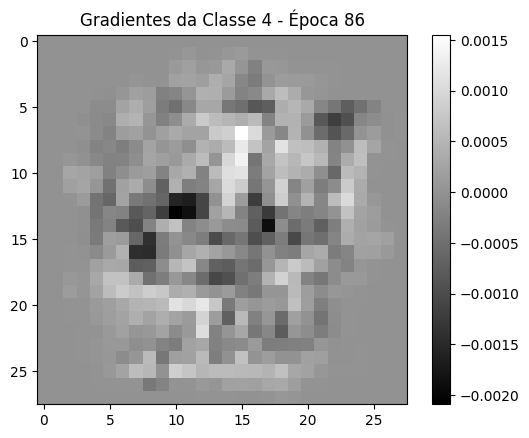

Epoch[87/100], Loss: 0.186649, Accuracy: 0.965000


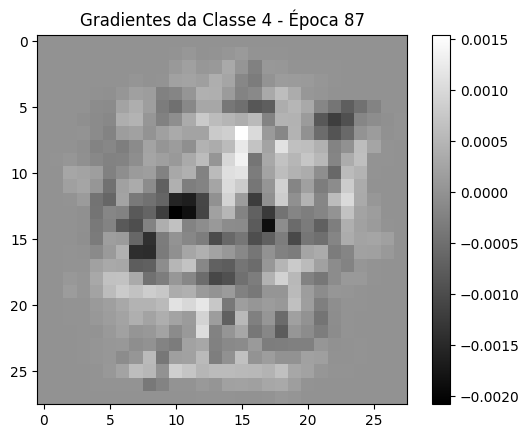

Epoch[88/100], Loss: 0.186021, Accuracy: 0.965000


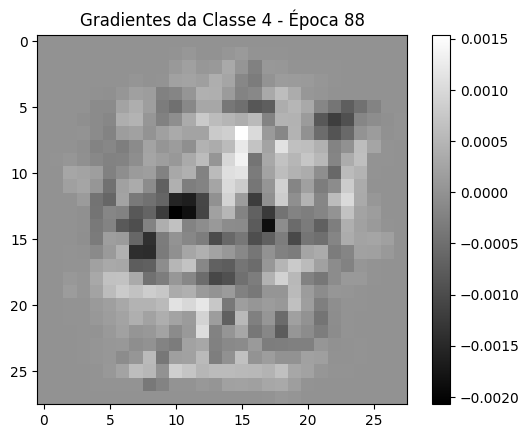

Epoch[89/100], Loss: 0.185398, Accuracy: 0.965000


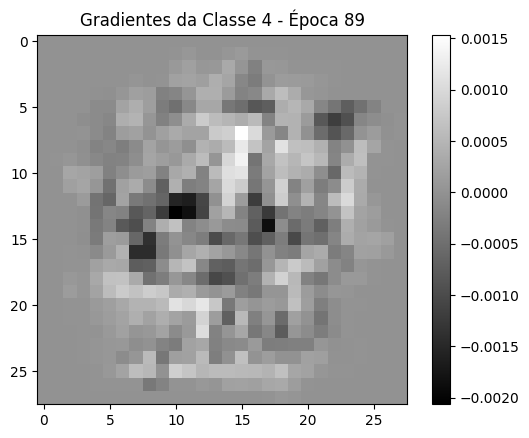

Epoch[90/100], Loss: 0.184778, Accuracy: 0.965000


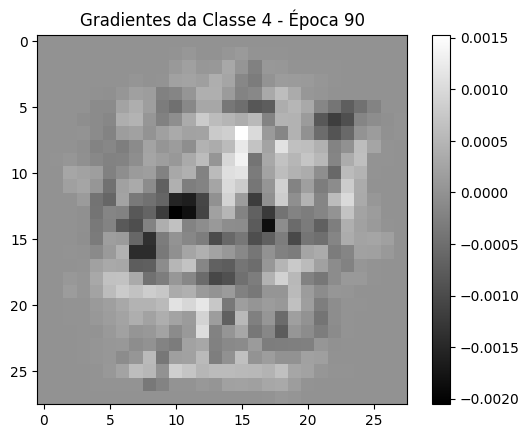

Epoch[91/100], Loss: 0.184163, Accuracy: 0.965000


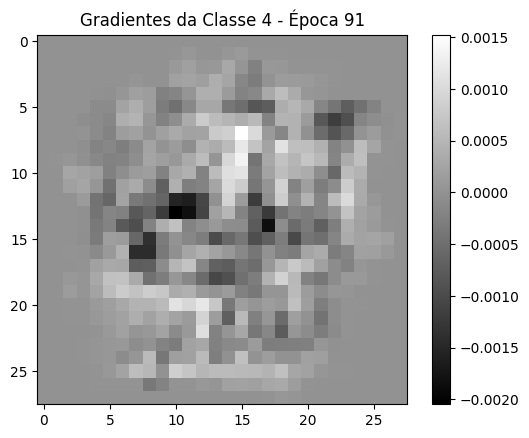

Epoch[92/100], Loss: 0.183552, Accuracy: 0.965000


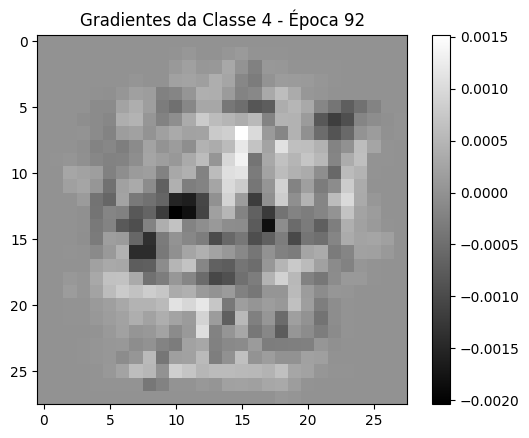

Epoch[93/100], Loss: 0.182945, Accuracy: 0.966000


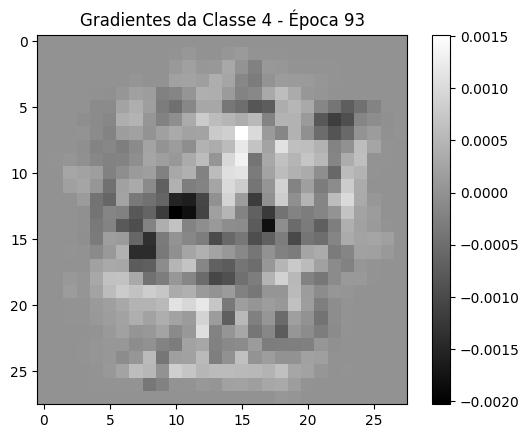

Epoch[94/100], Loss: 0.182341, Accuracy: 0.966000


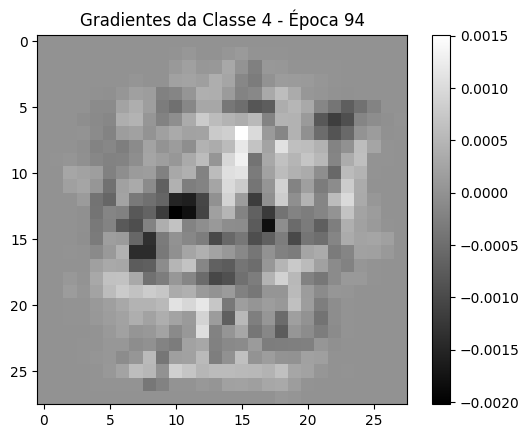

Epoch[95/100], Loss: 0.181742, Accuracy: 0.966000


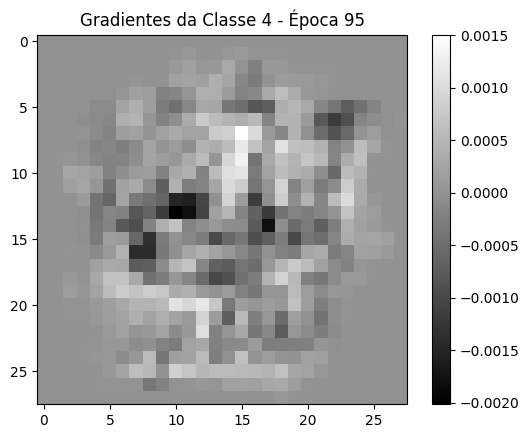

Epoch[96/100], Loss: 0.181146, Accuracy: 0.966000


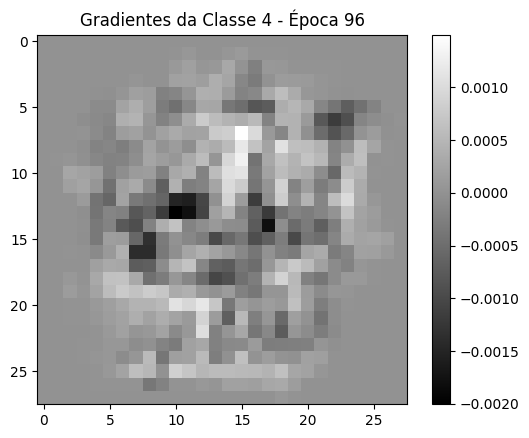

Epoch[97/100], Loss: 0.180554, Accuracy: 0.966000


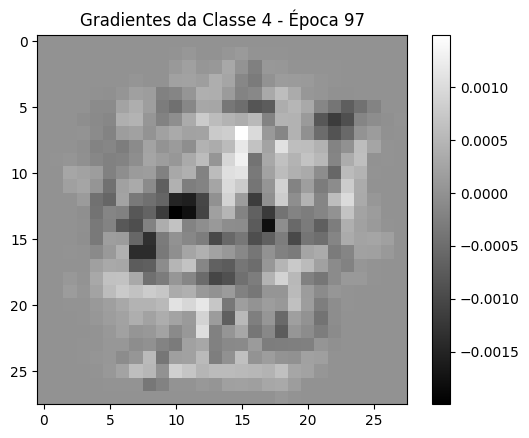

Epoch[98/100], Loss: 0.179966, Accuracy: 0.966000


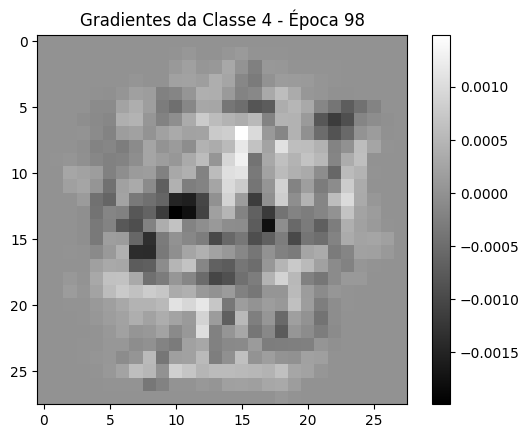

Epoch[99/100], Loss: 0.179381, Accuracy: 0.966000


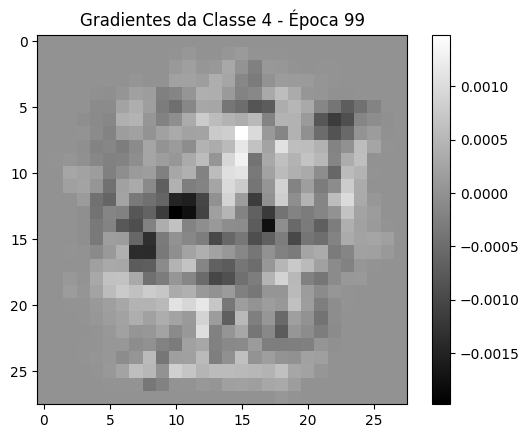

Epoch[100/100], Loss: 0.178800, Accuracy: 0.966000


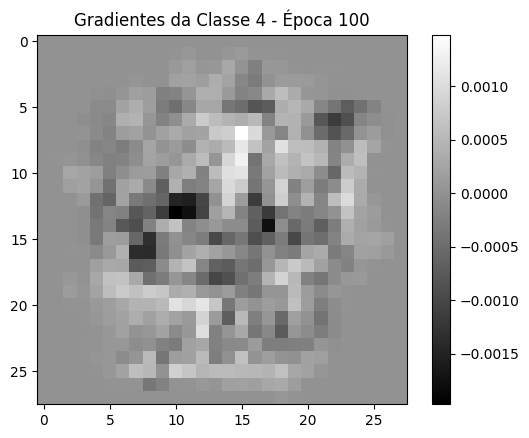

In [13]:
#Exercicio 2
for i in range(epochs):
    inputs = Variable(x_train.view(-1, 28 * 28))
    outputs = model(inputs)
    
    loss = criterion(outputs, Variable(y_train))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    _, predicts = torch.max(outputs, 1)
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print(f'Epoch[{i + 1}/{epochs}], Loss: {loss.item():.6f}, Accuracy: {accuracy:.6f}')
    
    # Exibe gradientes do peso referente à classe 4
    gradients = model.weight.grad[4].detach().numpy().reshape((28, 28))
    plt.imshow(gradients, cmap='gray')
    plt.colorbar()
    plt.title(f'Gradientes da Classe 4 - Época {i + 1}')
    plt.show()


### Visualização do grafo computacional da perda (loss)

In [14]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 680.0 kB/s eta 0:00:000:00:01
  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-594oycry
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-594oycry
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4971 sha256=07488a9bf43fbda831dba55f17e6226ddc2c93001f5ce9093296b5ba8824e985
  Stored in directory: /tmp/pip-ephem-wheel-cache-rf75rfm1/wheels/8a/88/98/69bcb99aba99a6bba9b2b81439cbda0101df40c49e639c4216
Successfully built torchviz


In [15]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(0.1782, grad_fn=<NllLossBackward0>)

In [16]:
p = make_dot(loss, dict(model.named_parameters()))
p

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Laço de treinamento dos pesos

In [17]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [18]:
print('Final loss:', loss.item())

Final loss: 0.13446098566055298


### Visualizando gráfico de perda durante o treinamento

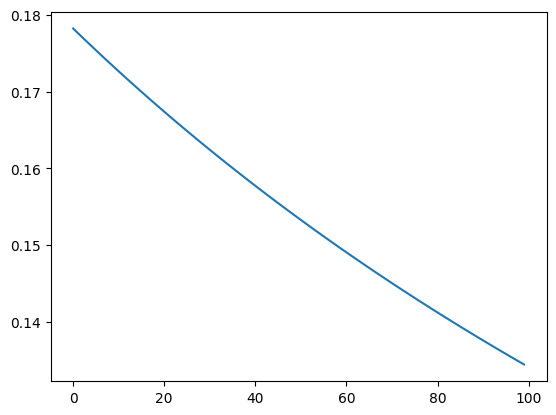

In [19]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [20]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.977


### Matriz de confusão com dados de treinamento e teste

In [21]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,97,0,0,0,0,0,0,0,0,2
1,0,114,1,0,0,0,0,0,0,0
2,0,0,94,1,0,1,0,1,0,0
3,0,0,0,91,0,0,0,0,0,0
4,0,0,0,0,104,1,0,1,0,1
5,0,1,0,1,0,88,0,0,1,1
6,0,0,1,0,0,1,94,0,0,0
7,0,0,1,0,0,0,0,115,0,2
8,0,0,1,0,0,0,0,0,86,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


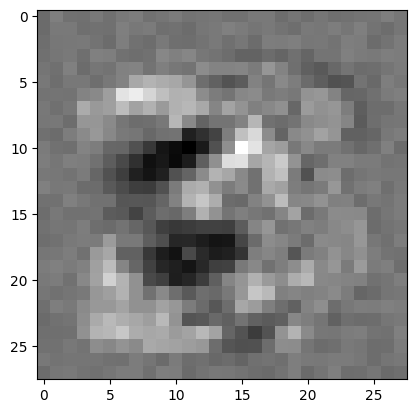

In [22]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

(np.float64(-0.5), np.float64(290.5), np.float64(29.5), np.float64(-0.5))

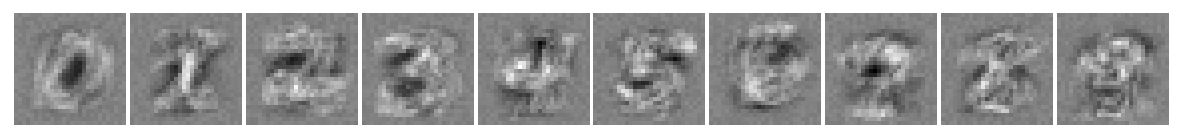

In [24]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

## Perguntas

Perguntas:

Qual é o shape da matriz de entrada na rede?
    O shape da matriz de entrada é (1000, 28, 28).
    Após o flatten (usando .view(-1, 28*28)), o shape se torna (1000, 784).

Qual é o shape da saída da rede?
    A saída da rede tem shape (1000, 10), onde 10 representa as pontuações (logits) para cada classe (dígitos de 0 a 9).

Qual é o número total de parâmetros da rede, incluindo o bias?
    São 7840 parâmetros de pesos (784 × 10) + 10 de bias. Totalizando 7850.

# Aprendizados
